# Medicare Clustering 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import seaborn as sns
import string
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
pd.options.display.max_rows = 1000

## Data Cleaning

### Loading Only Necessary Columns

In [2]:
# Renaming column names & grabbing relevant columns
columns = ['npi', 'last_name', 'first_name', 'middle_initial', 'credentials',
           'gender', 'entity_code', 'street_1,', 'street_2', 'city', 'zip',
           'state', 'country', 'provider_type', 'medicare_participation_indicator',
           'place_of_service', 'hcpcs_code', 'hcpcs_desc', 'hcps_drug', 'services_count',
           'unique_patients_count', 'unique_patients_day_count', 'average_allowed_amount',
           'average_submitted_charge', 'average_medicare_payment',
           'average_medicare_payment_standardized']

relevant_columns = ['gender', 'credentials', 'entity_code', 'city', 'state', 'country', 'provider_type', 
                    'medicare_participation_indicator', 'services_count', 'unique_patients_count', 
                    'unique_patients_day_count','average_allowed_amount', 'average_submitted_charge', 
                    'average_medicare_payment', 'average_medicare_payment_standardized']

relevant_numerical_columns = relevant_columns[8:]

df = pd.read_csv('CY2017.txt', sep="\t", header=0, skiprows=1, names=columns,
                 usecols=relevant_columns)

df['pocket'] = df['average_allowed_amount'] - df['average_medicare_payment']

### Removing Outliers from Numerical Data

In [3]:
def drop_numerical_outliers(df, z_thresh=4):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, result_type='reduce') \
        .all(axis=1)
    df.drop(df.index[~constrains], inplace=True)
rows = df.shape[0]
drop_numerical_outliers(df)

In [4]:
# Percentage of samples removed by dropping outliers 
percent_removed = round((rows - df.shape[0])/rows * 100, 2)
print(f'{percent_removed}% of data points have been removed')

1.1% of data points have been removed


### Addressing 0-values for Log Transformations

In [5]:
# Function to replace 0-values with adjusted means for log graphing
def zero_fixer(df, col):
    avg = df[col][df[col] > 0].mean()
    df.loc[df[col] == 0, col] = avg

# Apply function to these two columns 
zero_fixer(df, 'average_medicare_payment')
zero_fixer(df, 'average_medicare_payment_standardized')

## Exploratory Data Analysis 

### Histograms 

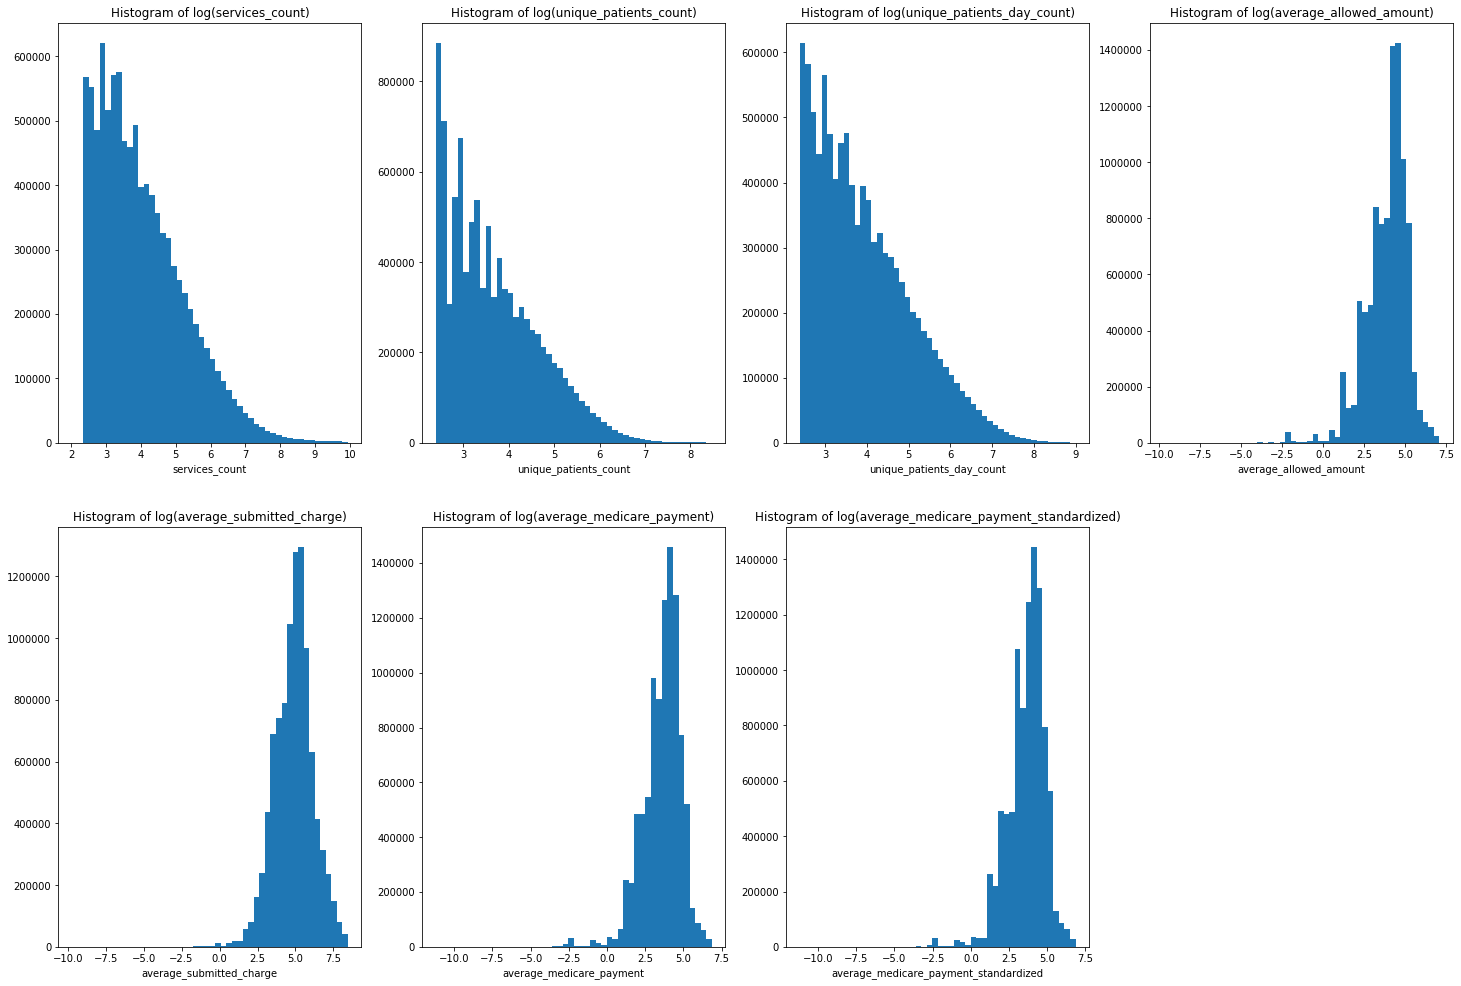

In [6]:
# Function to plot histograms for columns
def plotter(x, df):
    plt.hist(np.log(df[x]), bins=50)
    plt.xlabel(x)
    plt.title('Histogram of log(' + x + ')')
    

# Plot each column
j = 1 
plt.figure(figsize=(25,17))
for i in relevant_numerical_columns:
    plt.subplot(2, 4, j)
    plotter(i, df)
    j = j + 1

### Correllation Heatmap 

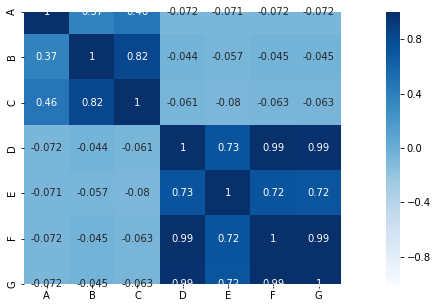

In [7]:
# Create a correlation heatmap for numerical columns
corr = df[relevant_numerical_columns].corr()
tick = list(string.ascii_uppercase[0:7])
plt.figure(figsize=(16, 5))
sns.heatmap(corr, xticklabels=tick, yticklabels=tick, square=True, vmin=-1, vmax=1, annot=corr, cmap ='Blues')
plt.show()

## Data Segmentation

### Data Fixing

In [8]:
# Converting categorical variables to numerical
df = pd.concat([df, pd.get_dummies(df['gender'],prefix='gender')],axis=1)
df.drop(['gender'],axis=1, inplace=True)

In [9]:
# Using transformed values for columns 
normal = ['average_allowed_amount', 'average_submitted_charge', 'average_medicare_payment',
          'average_medicare_payment_standardized']
for i in normal:
    df[i] = np.log(df[i])

### Data Trimming

In [10]:
# Looking only at medicare participants 
df = df.loc[df['medicare_participation_indicator'] == 'Y', :]

In [11]:
# Remove unncessary provider_types 
def provider_dropper(df, provider):
    df = df[df.provider_type != provider]
    return df
df = provider_dropper(df, 'All Other Suppliers')
df = provider_dropper(df, 'Unknown Supplier/Provider Specialty')

### Gathering *Training* and *Testing* Data

In [12]:
# Reset index
df = df.reset_index(drop=True)

In [13]:
# Sampling data from each provider type to keep representation consistent
def data_sampler(df, factor, it):
    keep = []
    for provider in it:
        sub_df = df[df.provider_type == provider]
        sample = sub_df.sample(frac = 1/factor, random_state = 0, axis = 0).index
        keep.append(sample)
    keep = [item for sublist in keep for item in sublist]
    return keep
it = set(df['provider_type'])
train = data_sampler(df, 100, it)

In [14]:
# Randomly selecting from unused data for testing
df_less_train = df[~df.index.isin(train)] 
test = df_less_train.sample(n = len(train), random_state = 1).index

## Clustering

### Standardize Data of Interest

In [15]:
cur_col = ['pocket', 'unique_patients_count']
scaler = StandardScaler()
std_df = df.loc[train, cur_col]
std_df = scaler.fit_transform(std_df)

### Scree Plot

In [16]:
# Finding SSE Values for various cluster sizes
maxClusters = 15
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(std_df)
    sse.append(kmeans.inertia_)

[143099.77132873161, 95366.50767892331, 70107.5766921308, 48471.07485808471, 38713.55450175242, 30829.17918307367, 26410.32842881865, 22583.097770713266, 20002.3751636648, 17929.755583398495, 16061.782617128261, 14613.959243092377, 13270.330681806578]


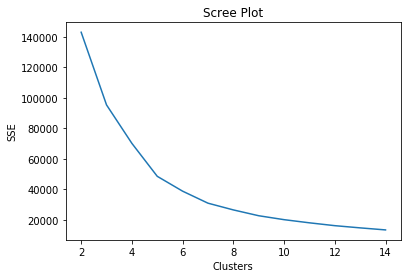

In [17]:
# Plotting SSE
print(sse)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.title('Scree Plot')
plt.plot(range(2,maxClusters),sse)
plt.show()

### Silhouette Scores

In [18]:
# Finding average silhouette score for various cluster sizes 
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(std_df)
    silhouette_avg = silhouette_score(std_df, kmeans.labels_, sample_size=10000)
    silh.append(silhouette_avg)

[0.5335226974955858, 0.5740921667319664, 0.4849282151718604, 0.5152271285524869, 0.5284519754504048, 0.4658320112123405, 0.4759991218399064, 0.46813062977151915, 0.46255799571808004, 0.47141513145215086, 0.44732548809892303, 0.43048353423955976, 0.4309532582984006]


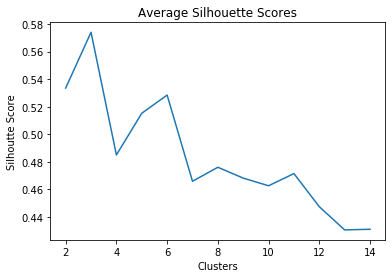

In [19]:
# Plotting average silhouette scores
print(silh)
plt.xlabel("Clusters")
plt.ylabel("Silhoutte Score")
plt.title("Average Silhouette Scores")
plt.plot(range(2,maxClusters),silh)

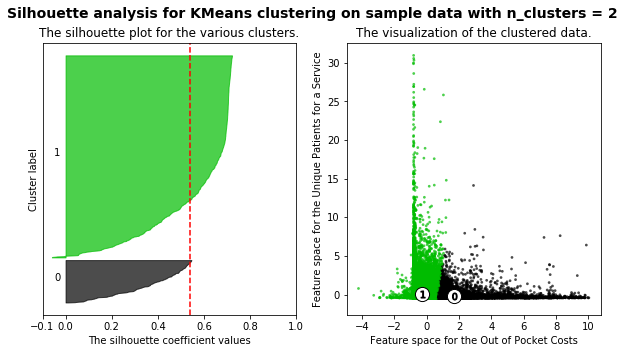

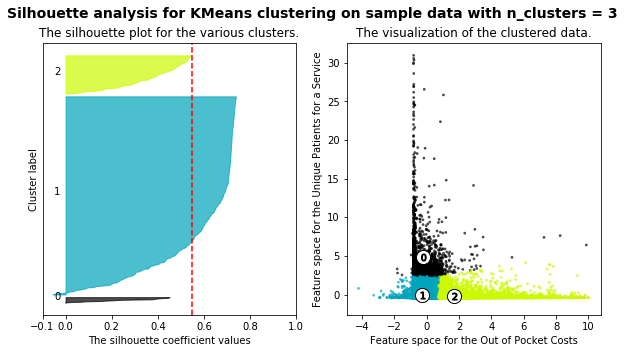

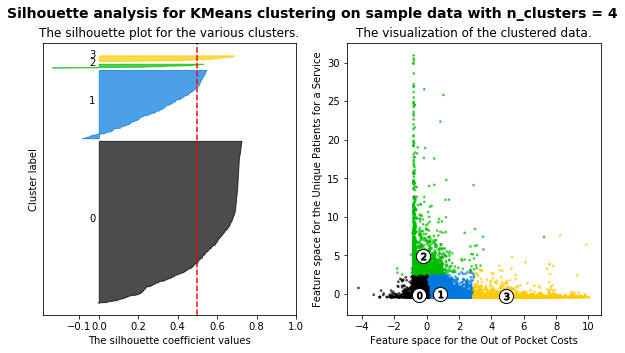

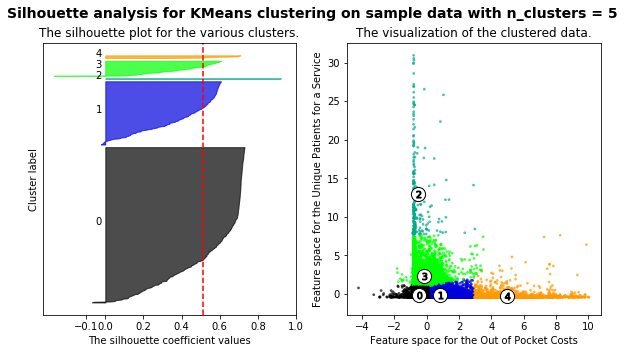

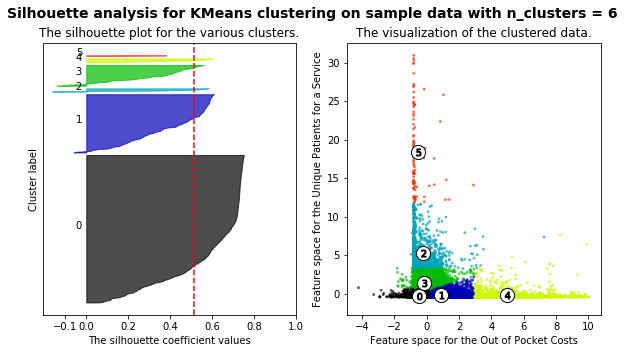

In [20]:
# Creating silhouette plots for a sample of values 
rel = [2,3,4,5,6]

for nClusters in rel:
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(std_df)
    indices = np.random.choice(std_df.shape[0], 1000, replace=False) 
    sample_silhouette_values = silhouette_samples(std_df[indices], kmeans.labels_[indices])
    
    # Lower bound for plot
    y_lower = 10
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    # Creating 
    for i in range(nClusters):
        ith_values = sample_silhouette_values[kmeans.labels_[indices] == i]
        ith_values.sort()

        size_cluster_i = ith_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / nClusters)

        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sample_silhouette_values.mean(), color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(kmeans.labels_.astype(float) / nClusters)
    ax2.scatter(std_df[:, 0], std_df[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the Out of Pocket Costs")
    ax2.set_ylabel("Feature space for the Unique Patients for a Service")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % nClusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Analysis

In [21]:
# Pulling Data again for clarity
cur_col = ['pocket', 'unique_patients_count']
scaler = StandardScaler()
std_df = df.loc[train, cur_col]
std_df = scaler.fit_transform(std_df)

In [22]:
# Grabbing labels when K = 3 Clusters
labels = KMeans(n_clusters=3, random_state=0).fit_predict(std_df)

In [23]:
# Creating df that has clusters and non-clustered information as well
data = df.loc[train, :]
data['Cluster'] = labels

In [24]:
# Looking at cluster frequencies 
print(data['Cluster'].value_counts(normalize = True))

1    0.827477
2    0.151974
0    0.020549
Name: Cluster, dtype: float64


In [25]:
# Finding 
for i in range(3):
    print(data.loc[data.Cluster == i]['provider_type'].value_counts(normalize = True))

Diagnostic Radiology                              0.1580
Clinical Laboratory                               0.1165
Cardiology                                        0.0980
Ophthalmology                                     0.0845
Internal Medicine                                 0.0820
Dermatology                                       0.0595
Urology                                           0.0425
Family Practice                                   0.0415
Emergency Medicine                                0.0380
Pathology                                         0.0320
Ambulance Service Provider                        0.0185
Orthopedic Surgery                                0.0170
Podiatry                                          0.0170
Optometry                                         0.0160
Nurse Practitioner                                0.0150
Endocrinology                                     0.0135
Physician Assistant                               0.0135
Interventional Cardiology      

In [26]:
for i in normal:
    data[i] = np.exp(data[i])

In [27]:
data[['Cluster', 'unique_patients_count', 'pocket', 'services_count', 'average_submitted_charge']].groupby('Cluster').mean()

,unique_patients_count,pocket,services_count,average_submitted_charge
Cluster,,,,
0,789.684000,15.366059,1357.885950,175.516889
1,60.659080,13.047823,153.621036,187.129310
2,55.939355,63.910223,74.633703,813.542266


## Testing

In [28]:
cur_col = ['pocket', 'unique_patients_count']
scaler = StandardScaler()
std_df = df.loc[train, cur_col]
std_df = scaler.fit_transform(std_df)

In [29]:
# Standardize Testing Data
scaler = StandardScaler()
std_df = df.loc[test, cur_col]
std_df = scaler.fit_transform(std_df)

In [30]:
test_labels = kmeans.predict(std_df)

data = df.loc[test, :]
data['Cluster'] = test_labels

In [31]:
print(data['Cluster'].value_counts())

0    61458
1    24171
3     8714
4     1760
2     1124
5       99
Name: Cluster, dtype: int64


In [32]:
for i in normal:
    data[i] = np.exp(data[i])

In [33]:
data[['Cluster', 'unique_patients_count', 'pocket', 'services_count', 'average_submitted_charge']].groupby('Cluster').mean()

,unique_patients_count,pocket,services_count,average_submitted_charge
Cluster,,,,
0,41.420922,9.319727,128.573789,149.989181
1,46.511026,42.936072,64.370775,547.929749
2,830.127224,15.189287,1465.446441,166.831007
3,273.446179,16.726345,527.080250,186.916208
4,46.575568,145.372606,70.391477,1888.200571
5,2531.929293,13.391315,3967.636364,230.999075


In [34]:
for i in range(3):
    print(data.loc[data.Cluster == i]['provider_type'].value_counts())

Diagnostic Radiology                                9787
Internal Medicine                                   7178
Family Practice                                     7041
Nurse Practitioner                                  3994
Physician Assistant                                 2536
Physical Therapist in Private Practice              2514
Cardiology                                          2400
Orthopedic Surgery                                  1759
Pathology                                           1246
Podiatry                                            1191
Hematology-Oncology                                 1148
Mass Immunizer Roster Biller                        1138
Anesthesiology                                      1110
Emergency Medicine                                  1036
Ophthalmology                                        976
Urology                                              955
Optometry                                            844
General Surgery                